In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
    
from joblib import Parallel, delayed

### Metropolis algorithm

1) Finds location of nearest neighbours

2) Calculates the the energy to flip spins 

3) if energy is reduced, config is updated

4) otherwise its updated wrt. how likley the change is

In [32]:
L = 100
J = 1

def neighbours(loc, L):
    """
    Takes a location (loc) and finds the nearest neighbours
    up down left and right, and returns those co-ordinates
    """
    return [np.mod(loc + diff, L) for diff in [[1, 0], [-1, 0], [0, 1], [0, -1]]]
    

def flip_energy_cost(config, spin, L):
    """
    sums total spin of neighbours and calculates the total energy from flipping spin
    """
    neighbors_sum = np.sum([config[i[0], i[1]] for i in neighbours(spin, L)])
    return 2*J*config[spin[0], spin[1]]*neighbors_sum
    
# perform a single step of the Metropolis algorithm on the configuration 'config' with 1/kT = 'beta'
def metropolis_step(config, beta, L):
    """
    Metropolis algorithm single step:
        - choose random point
        - find energy state if that point flipped
        - choose to keep the original config or use new one based on energy considerations
            ~ lower energy => better
            ~ non 0 chance of taking higher energy state

    1/kT = beta (thermodynamic coldness)
    """
    flipspin = np.random.randint(0, L, size = 2)
    energy_cost = flip_energy_cost(config, flipspin, L)
    
    if energy_cost <= 0:
        config[flipspin[0], flipspin[1]] = -config[flipspin[0], flipspin[1]]
    elif np.random.random() <= np.exp(-beta*energy_cost):
        config[flipspin[0], flipspin[1]] = -config[flipspin[0], flipspin[1]]
    
    return config

## Run Through Metropolis algo

250,000 runs

takes a evenly spaced snapshots

In [3]:
init_config = np.random.choice([1, -1], size = (L, L))
configs_list = [init_config.copy()]

for i in range(250000):
    init_config = metropolis_step(init_config, beta = 10)

    if i%2500 == 0:
        configs_list.append(init_config.copy())

In [9]:
fig = plt.figure()
im = plt.imshow(configs_list[0], vmin = -1, vmax = 1, cmap='Greys', animated=True)
plt.close()

# function that updates the figure
def update(frame):
    im.set_array(frame)

plt.rcParams["animation.html"] = "jshtml"
from IPython.display import HTML
ani = animation.FuncAnimation(fig, update, frames=configs_list, interval=50)
HTML(ani.to_jshtml())

## Magnetism

With the overall spin clusters you can calculate the magnetism which is the average spin of a particle

In [33]:
def final_magnetization(iterations, beta, L):
    """
    initialises a system with random spins
    optimises using the metropolis algorithm
    returns the total magnetisation and beta
    """
    init_config = np.array([[1 for i in range(L)] for j in range(L)])
    
    for i in range(iterations):
        startinit_configonf = metropolis_step(init_config, beta, L)
    
    magnetization = np.sum(init_config)/L**2
    return [beta, magnetization]

#final_magnetizations = np.array(Parallel(n_jobs = 5)(delayed(final_magnetization)(80000, beta) for beta in np.arange(0,1,0.01)))

Text(0, 0.5, 'Magnetisation')

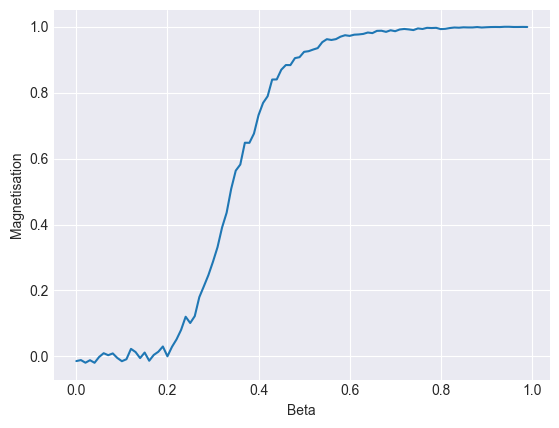

In [21]:
plt.style.use("seaborn-v0_8-darkgrid")
plt.plot(final_magnetizations[:,0], final_magnetizations[:,1])
plt.xlabel("Beta")
plt.ylabel("Magnetisation")

Testing over a range of L

In [34]:
Ls = [15 + i for i in range(0, 11, 2)]
mags_list = []
for l in Ls:
    mags_list.append(np.array(Parallel(n_jobs = 5)(delayed(final_magnetization)(300000, beta, l) for beta in np.arange(0,1,0.05))))

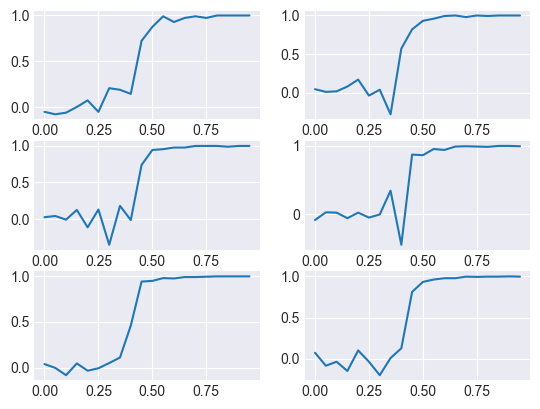

In [35]:
fig, axs = plt.subplots(3,2)
for ax, mag in zip(axs.flatten(), mags_list):
    ax.plot(mag[:,0], mag[:,1])
plt.show()
